In [1]:
%matplotlib notebook
import numpy as np
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
class convex_hull_3D():
    
    def __init__(self, dataset, delta_phi, delta):
        self.data = dataset           # shape N x dim=3 
        self.hull_pts = []            # initialized as an empty list
        self.phi = 0
        self.delta = delta
        self.delta_phi = delta_phi
        self.data_copy = dataset
        self.hull_data = []
        self.not_hull = []
        self.num_pts = 0
        
        # Fixed rotation matrix:
        self.R_phi = np.array([ [np.cos(self.delta_phi), -np.sin(self.delta_phi),   0],
                                [np.sin(self.delta_phi),  np.cos(self.delta_phi),   0],
                                [               0,                 0,               1]  ])
    
    
    def center_about_mean(self):
        # computing the lowest point / mean point
        # lowest = self.data[list(self.data[:,2]).index(np.min(self.data[:,2])), :]
        mean_pt = self.data.sum(axis=0)/3
        self.data = self.data - mean_pt
    
    
    
    def rotate_by_delta_phi(self):
        # Update the angle! (not used to compute the rotation matrix - that is precomputed)
        self.phi = self.phi + self.delta_phi
        # Rotate by delta_phi again!
        self.data = ( self.R_phi @ self.data.T ).T          # 3x3 @ 3xN
        
    
    
    def project_rotated_pts(self):
        # Since we are rotating the points, their projections are just their new coordinates... right?
        # Only considering the Y, Z coordinates...
        self.data_2D = self.data[:,1:]                       # all N points but only columns 2 and 3
        
        
    
    def convex_hull_indices(self): 
        
        self.hull = []
        highest_pt = self.data_2D[list(self.data_2D[:,1]).index(np.max(self.data_2D[:,1])), :]
        self.hull.append(list(self.data_2D[:,1]).index(np.max(self.data_2D[:,1])))
        
        next_highest = highest_pt
        count = 0
        cum_theta = 0
        
        # Make the masks for the hull and the interior points in the 2D dataset being used to calculate the 
        # ... convex hull of in this function instance!
        hull_mask = np.asarray(np.ones(len(self.data_2D)) != 1.0)               # all false
        
        # Updating the hull mask with the highest point!
        mask1 = (abs(self.data_2D[:,0]-next_highest[0]) < 10**(-10))
        mask2 = (abs(self.data_2D[:,1]-next_highest[1]) < 10**(-10))
        hull_mask += (mask1 * mask2)                 # true only for highest point
        
        not_hull_mask = (hull_mask == False)                    # complement of hull_mask array!
        
        R = np.array([[1, 0], [0, 1]])
        
        while cum_theta < 2*np.pi:          # stops when cum_theta == 2pi
            count = 0;      val = False
            while val == False:
                rotated_pts = self.data_2D @ R
                maxY = np.max(rotated_pts[:,1])
                ind_highest = list(rotated_pts[:,1]).index(maxY)
                next_highest = rotated_pts[ind_highest, :]
                R_inv = np.array([[np.cos(cum_theta+count*self.delta), -np.sin(cum_theta+count*self.delta)],
                                  [np.sin(cum_theta+count*self.delta),  np.cos(cum_theta+count*self.delta)]])
                next_highest = next_highest @ R_inv
                count += 1
                R = np.array([[ np.cos(cum_theta + count*self.delta), np.sin(cum_theta + count*self.delta)],
                              [-np.sin(cum_theta + count*self.delta), np.cos(cum_theta + count*self.delta)]])
                n_h = np.array([round(next_highest[0], 5), round(next_highest[1], 5)])
                h_p = np.array([round(  highest_pt[0], 5), round(  highest_pt[1], 5)])
                diff = n_h - h_p
                val = diff.any()
                
            cum_theta += count * self.delta
            highest_pt = next_highest
            if ((abs(highest_pt[0]-self.data_2D[self.hull[0]][0])<10**(-8)) and (abs(highest_pt[1]-self.data_2D[self.hull[0]][1])<10**(-8))):
                break
            else:
                self.hull.append(ind_highest)    # THESE ARE INDICES!!!!
                mask1 = np.asarray(abs(self.data_2D[:,0]-next_highest[0]) < 10**(-5))   # will be True only for a few pts
                mask2 = np.asarray(abs(self.data_2D[:,1]-next_highest[1]) < 10**(-5))   # will be True only for a few pts
                hull_mask += mask1 * mask2
                
        # not_hull = [self.data_2D[i] for i in range(len(self.data_2D)) if not_hull_mask[i] == True]
        not_hull_mask = np.asarray(hull_mask == False)
        self.interiors = [int(i) for i in range(len(self.data_2D)) if not_hull_mask[i] == True]
        
        """
        print('\nThese should be eq: {} and {}'.format(len(self.hull), hull_mask.sum()))
        print('These should be eq: {} and {}'.format(len(self.interiors), not_hull_mask.sum()))
        """
        
        return hull_mask
        
        
    
    def alpha_shape(self, dataset):
        
        self.data = dataset
        
        self.not_alpha_hull = dataset    # Initializing!
        
        highest_pt = dataset[list(dataset[:,1]).index(np.max(dataset[:,1])), :]
        self.alpha_hull.append(highest_pt)                 # append this first highest pt to the list of points in the convex hull
        next_highest = highest_pt
        
        self.centroid = np.array([np.mean(dataset[:,0]), np.mean(dataset[:,1])])
        
        count = 0
        cumulative_theta = 0                               # cumulative rotation angle of the whole figure!
        eps = 10**(-10)
        
        # non_hull_mask = non_hull_mask * ((dataset[:,0] != highest_pt[0]) + (dataset[:,1] != highest_pt[1]))
        not_hull_mask = (np.ones(len(self.data)) == 1) 
        not_hull_mask *= ((self.data[:,0] != highest_pt[0]) + (self.data[:,1] != highest_pt[1]))
        
        # R and R inverse
        R     = lambda theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
        R_inv = lambda theta: np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta),  np.cos(theta)]])
        
        count = 0
        
        while cumulative_theta<2*np.pi:
            
            # 1. Calculate the set of points within "alpha" distance of the current highest_pt!
            alpha_data = [self.not_alpha_hull[i] for i in range(len(self.not_alpha_hull)) if (np.linalg.norm(self.not_alpha_hull[i]-highest_pt)<=self.alpha)and(np.linalg.norm(self.not_alpha_hull[i]-highest_pt)>0)]
            # Adding to alpha_data the value of the first hull point which is not in not_alpha_hull!
            if (count>0) and (np.linalg.norm(highest_pt-self.alpha_hull[0])<=self.alpha):
                alpha_data.append(self.alpha_hull[0])
            # list --> array
            alpha_data = np.asarray(alpha_data)
            
            # Check to make sure this list is NOT EMPTY!(There have to be values inside the alpha circle radius!)
            if len(alpha_data) == 0:
                print('alpha not big enough :(')
                break
            
            # 2. Calculating the value of the angles!
            if count == 0:
                pt1 = -self.alpha*np.array([1, 0])                   # The new highest_pt!
                theta1 = 0                                           # 
                pt2 = alpha_data - highest_pt                        # 
                thetas = []
                for i in range(len(pt2)):
                    theta2 = np.arctan2(pt2[i][1], pt2[i][0])
                    angle_in_btw = theta2 if theta2>0 else 2*np.pi-abs(theta2)
                    thetas.append(angle_in_btw)
                thetas = np.asarray(thetas)
            else:
                thetas = self.vector_direction(highest_pt, alpha_data, self.alpha_hull[-2])
            
            #### Plot the thetas!!!
            #### self.plot_thetas(alpha_data, highest_pt, thetas)
                
            # Now we find the minimum of all the angles!
            min_theta = np.min(thetas)
            if count == 0:
                cumulative_theta = min_theta
            else:
                cumulative_theta = np.maximum(min_theta, cumulative_theta)
            
            # Calculate next CORRECT alpha shape point using this smallest theta value!
            next_highest = alpha_data[list(thetas).index(min_theta),:]
            
            # 9. PLOT THE CONSTRUCTION PROCESS!!
            if self.construct_process == True:
                self.plot_alpha_shape_construction(alpha_data, highest_pt, next_highest, thetas)   # count should help us calculate the next cum_theta value inside the plot_construction function!
            
            # 10. Append the next pt to the list of hull_pts
            highest_pt = next_highest
            
            if ((abs(highest_pt[0]-self.alpha_hull[0][0])<10**(-8)) and (abs(highest_pt[1]-self.alpha_hull[0][1])<10**(-8))):
                break                                           # BREAK from the outer while loop
            else:
                self.alpha_hull.append(highest_pt)              # appending the new highest pt to the list
                # 9. Updating the not_hull_mask!   {if the difference is really really small}
                mask1 = (abs(dataset[:,0]-next_highest[0]) > 10**(-10))
                mask2 = (abs(dataset[:,1]-next_highest[1]) > 10**(-10))
                not_hull_mask = not_hull_mask * (mask1 + mask2)
            
            count += 1
            
            self.not_alpha_hull = [dataset[i] for i in range(len(dataset)) if not_hull_mask[i] == True]
    
    
    
    def plot_intermediate_2D(self):
        
        # Plotting the current instance of the convex hull
        plt.figure(figsize=(5,5))
        plt.scatter(self.data_2D[self.interiors,0], self.data_2D[self.interiors,1], s=10, c='b', marker='o')
        plt.scatter(self.data_2D[self.hull,0], self.data_2D[self.hull,1], s=20, c='r', marker='x')
        plt.title('2D Convex hull')
        plt.show()
        
        
        
    def plot_intermediate_convex_hull(self):
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(projection='3d')
        
        h_x = self.data_copy[self.hull,0];    nh_x = self.data_copy[self.interiors, 0]
        h_y = self.data_copy[self.hull,1];    nh_y = self.data_copy[self.interiors, 1]
        h_z = self.data_copy[self.hull,2];    nh_z = self.data_copy[self.interiors, 2]
        
        ax.scatter(nh_x, nh_y, nh_z, s=30, c='b', marker='o')
        ax.scatter( h_x,  h_y,  h_z, s=30, c='r', marker='o')
            
        plt.title('Intermediate Convex Hull')
        plt.show()
    
    
    
    def plot_hull_points(self):
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(projection='3d')
        plt.title('Hull points')
        
        ax.scatter(self.hull_data[:,0], self.hull_data[:,1], self.hull_data[:,2], s=25, c='r', marker='o')
        ax.scatter(self.not_hull[:,0], self.not_hull[:,1], self.not_hull[:,2], s=8, c='k', marker='o')
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.grid(True)
        plt.show()
        
       
    
    
    def rect_to_spherical(self):
        
        x = self.hull_data[:,0];  y = self.hull_data[:,1];  z = self.hull_data[:,2]
        
        self.r     = np.sqrt(x**2 + y**2 + z**2)
        self.phi   = np.arctan(np.sqrt(x**2 + y**2)/z)
        self.theta = np.arctan(y/x)
    
    
    
    """
    def triangulation(self):
        
        # start with the top most point??
        
        # 1. Compute the closest point to the current point in terms of the smallest Del phi and Del theta
        # ... and connect it to the very first point (the top most point)!
        
        # 2. Now we need to calculate points to the right and the left of this line segment...
        # ... these points must be such that the circumcircle they form must be empty of other points
        # ... AND the triangle so formed have the maximize of all possible minimum interior angles.
        
        # 3. For the highest point we sort the others in order of promixity of sqrt(phi**2 + theta**2)
        # ... and pick one after the other 
    """
    
    
    
    def global_hull(self):
        
        self.center_about_mean()
        
        self.not_hull_mask = np.asarray(np.ones(len(self.data)) != 1.0)    # all False
        self.hull_mask     = np.asarray(np.ones(len(self.data)) != 1.0)    # all False
        
        while self.phi < 2*np.pi:
            
            self.rotate_by_delta_phi()                           # Rotated by a certain angle!
            # print('\n\nRotated the points by: ', self.phi*180/np.pi)
            
            self.project_rotated_pts()
            
            hull_bool = self.convex_hull_indices()
            self.hull_mask += hull_bool
            
            if self.hull_mask.sum() > self.num_pts:
                self.num_pts = self.hull_mask.sum()
                # print('\n\nHull indices: ')
                # print(self.hull)
                # print('Total no. of hull points so far: ', self.hull_mask.sum())
                # self.plot_intermediate_convex_hull()
                # self.plot_intermediate_2D()
        
        # Creating the hull points and the not hull points
        for i in range(len(self.not_hull_mask)):
            if self.hull_mask[i]==False:
                self.not_hull.append(self.data_copy[i,:])
            else:
                self.hull_data.append(self.data_copy[i,:])
        
        self.hull_data = np.asarray(self.hull_data)
        self.not_hull  = np.asarray(self.not_hull)
        
        # after exiting the loop, we will have all the 3D hull points!
        self.plot_hull_points()
        
        # Convert to spherical coordinates:
        self.rect_to_spherical()                    # now we have self.r, theta and phi!
        
        # 
        
        
        # 
        

<IPython.core.display.Javascript object>


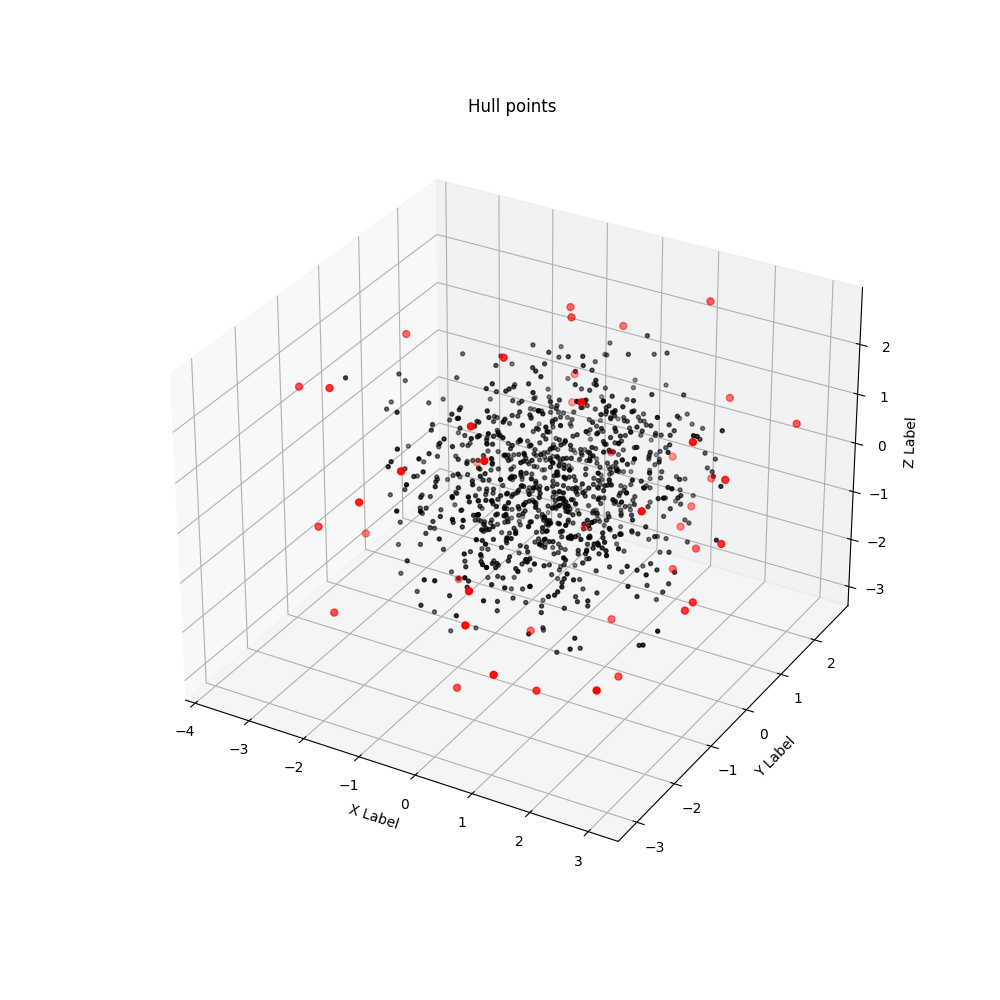

In [3]:
# Generate test 3D point cloud
N = 1000
data = np.random.randn(N, 3)
# x = data[:,0];    y = data[:,1];    z = data[:,2]

# data = np.vstack((x, y, z)).T
# print('shape of data: ', data.shape)

c3 = convex_hull_3D(data, delta_phi=np.pi/250, delta=np.pi/200)

c3.global_hull()